# Data Inspection

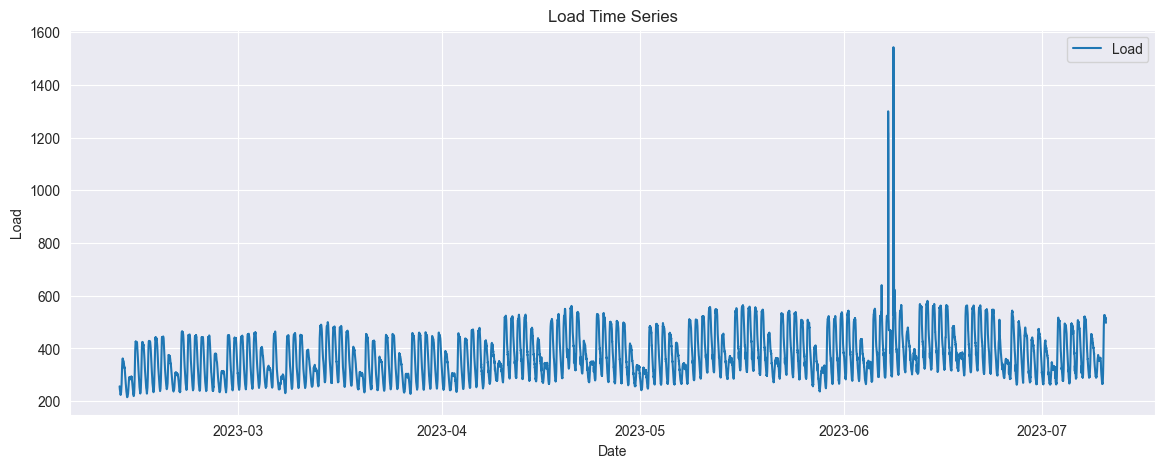

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
file_path = "./data/weatherkit_plus_load.csv"  # Update with actual path
df = pd.read_csv(file_path, parse_dates=['event_timestamp'], index_col='event_timestamp')

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['load_MW'], label='Load')
plt.title('Load Time Series')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.show()

# Sample the data based on hourly for cyclic checks

1. Early Morning Dip (2 AM – 6 AM)
Load is at its lowest between 2:00 AM and 6:00 AM, which likely reflects minimal activity — most people are asleep, and systems/processes may be running at reduced capacity.

2. Sharp Increase After 6 AM
There’s a noticeable surge in load starting around 7–8 AM, possibly reflecting:
    - Start of business hours

    - Equipment/system activation

    - Increased energy demand from people starting their day

3. Peak Period: 10 AM – 4 PM
Load plateaus at a high level between 10:00 AM and 4:00 PM, suggesting this is the core active window — consistent with working hours or industrial usage.

4. Gradual Decline After 4 PM
Load steadily drops after 5 PM, reaching a second lower plateau after 8–9 PM, though still higher than early morning levels.The hourly profile of load shows a distinct diurnal pattern: lowest usage occurs between 2–6 AM, followed by a sharp rise peaking between 10 AM and 4 PM. This indicates that load is strongly influenced by daily human activity cycles or operational schedules. Features based on hour of day (or cyclical encodings) would likely improve forecasting performance.

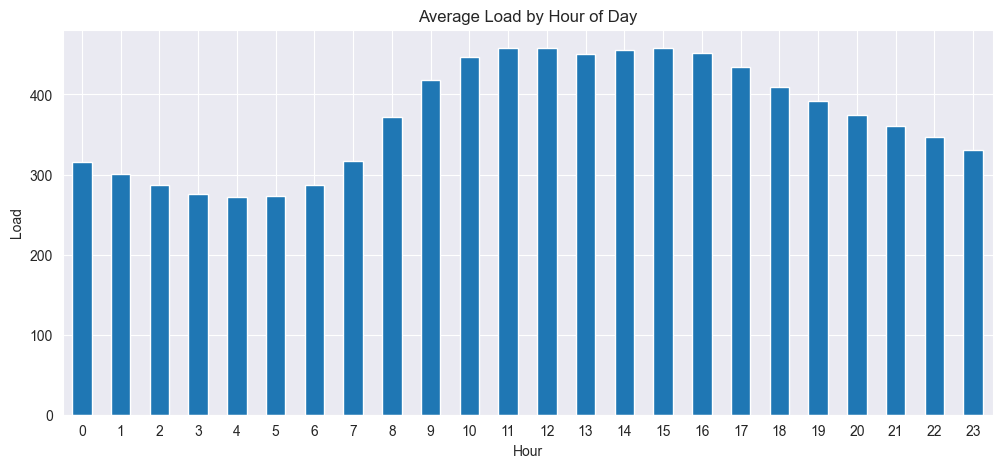

In [10]:
df_hourly = df['load_MW'].resample('h').mean()  # Resample to hourly frequency
df['Hour'] = df.index.hour
hourly_profile = df.groupby('Hour')['load_MW'].mean()

hourly_profile.plot(kind='bar', figsize=(12, 5))
plt.title('Average Load by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Load')
plt.xticks(rotation=0)
plt.show()

# Sample the data based on daily for seasonal checks
Overall Upward Drift: Between early March and mid/late May there seems to be a general rising trend (from around the 300 range to nearly 450).

Cyclical or “Wave‐Like” Fluctuations: Even though there’s an upward trend, the line oscillates regularly. This is often an indication that there may be a weekly pattern or shorter cycles present in the data.

Peaks and Troughs: Notice how every few days the load dips significantly, then rebounds. That kind of repetition could be a clue about consistent day‐of‐week effects or other regular patterns in usage/production.

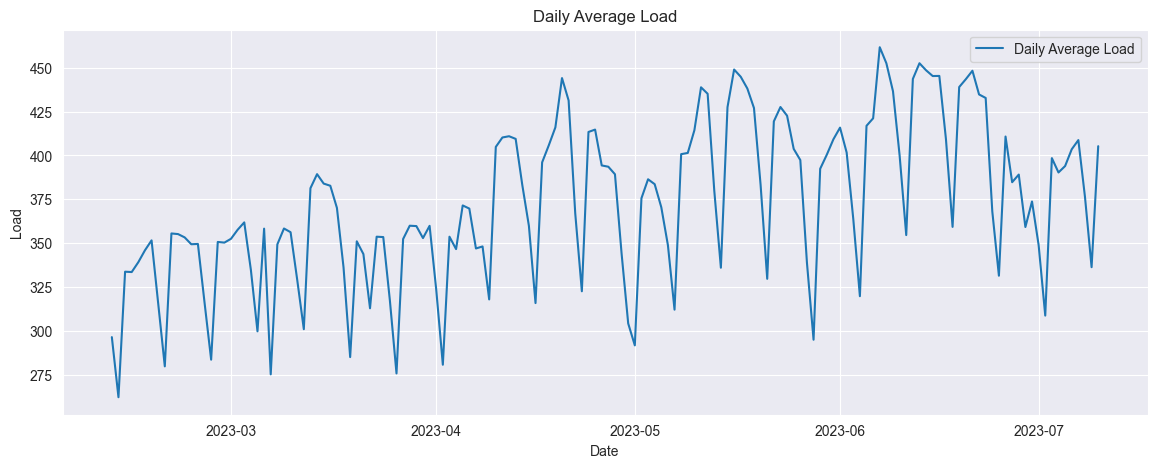

In [5]:
df_daily = df['load_MW'].resample('D').mean()  # Resample to daily frequency
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily, label='Daily Average Load')
plt.title('Daily Average Load')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.show()

# Sample data base on day of week

The plot shows the highest loads occur mid‐week (Wednesday/Thursday), while Saturday and Sunday average loads drop significantly. Monday and Friday are mid‐range, reflecting a typical workweek pattern where usage is highest in the middle of the week and tapers off on weekends.

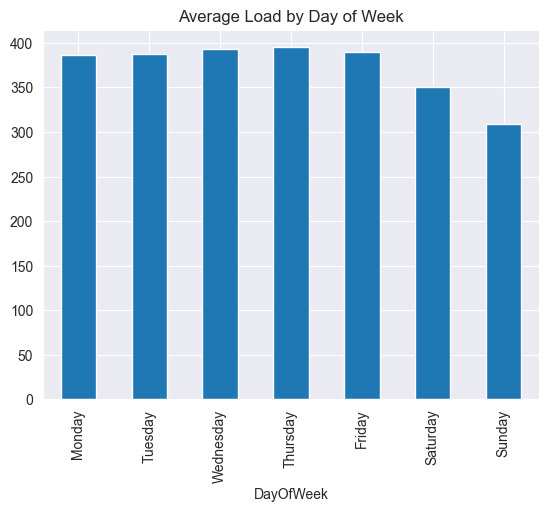

In [6]:
df['DayOfWeek'] = df.index.day_name()  # or df.index.dayofweek
df_dayofweek = df.groupby('DayOfWeek')['load_MW'].mean()
ordered_days = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
df_dayofweek = df_dayofweek.reindex(ordered_days)
df_dayofweek.plot(kind='bar')
plt.title('Average Load by Day of Week')
plt.show()


# Sample based on
Overall Rising Trend: From late February (around 280) through to May (peak above 420), there’s a general upward drift. This could reflect increasing demand, seasonality, or gradual changes in operations/habits.

Intermediate Dips and Bounces: Even with weekly smoothing, you can still see some intermediate drops (for example, in early April and mid-June), but they’re not as sharp as in the daily data.

Seasonal Behavior: If the timeframe were extended or if you had multiple years of data, you might observe more pronounced seasonal cycles. Even in this shorter window, you can see that the weekly average ebbs and flows, with higher loads around late spring and slightly lower in early summer.

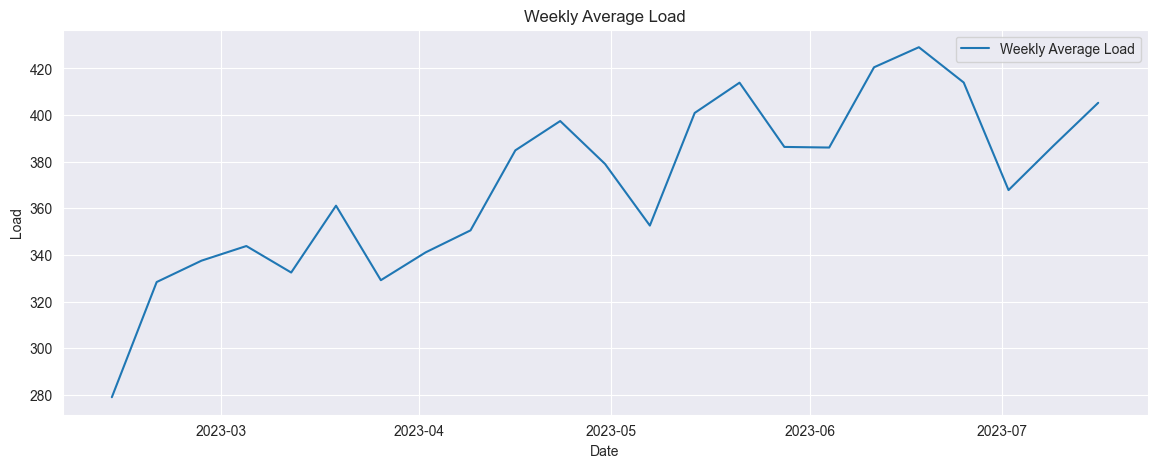

In [7]:
df_weekly = df['load_MW'].resample('W').mean()  # Resample to weekly frequency
plt.figure(figsize=(14, 5))
plt.plot(df_weekly.index, df_weekly, label='Weekly Average Load')
plt.title('Weekly Average Load')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.show()

# Trend Analytics Daily
1. Observed (Top Plot)
This is the actual daily average load time series — the one you originally plotted. It's a combination of the trend, seasonality, and residual components.

2. Trend
You can see a slow-moving upward pattern, with load increasing from Feb through early June, then dipping slightly in July. However, this is a local trend, not necessarily a yearly trend — as you correctly noted earlier, it shouldn't be generalized without more data.

3. Seasonal
Very clear weekly seasonality! That sawtooth pattern with a period of 7 days confirms that load strongly varies by day of the week. This aligns perfectly with the earlier bar chart where you saw weekends having lower load than weekdays.

4. Residual (Noise)
These are the random fluctuations not explained by trend or seasonality.

Looks fairly centered around 0 with occasional spikes — suggesting your additive model fits the data reasonably well.

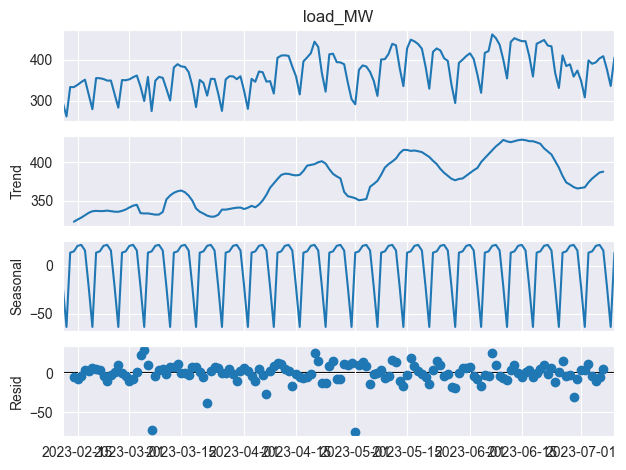

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose (for example, daily data). 'period' should match expected seasonality (e.g. 7 for weekly if daily data).
daily_result = seasonal_decompose(df_daily, model='additive', period=7)

# Plot decomposition
daily_result.plot()
plt.show()


# Trend Analytics Hourly
1. Observed (Top Plot)
You can clearly see daily repeating spikes — typical for systems where load varies greatly between night and day.

There's one extreme spike (outlier) around early June — something likely unusual or anomalous.

2. Trend
The trend shows a smoothed version of your overall hourly load.

There’s a general increase through April to June, but again, the spike in June distorts the trend a bit.

3. Seasonal Component
This stripy band shows strong daily seasonality — every 24 hours, the pattern repeats consistently.

The magnitude looks stable, reinforcing the earlier “average load by hour” bar chart: clear high/low cycles throughout each day.

4. Residual (Noise/Unexplained Component)
The residual is mostly tight and stable — except for a clear outlier in June (matching the observed spike).

That suggests the decomposition model fits well most of the time, except during rare anomalous behavior.



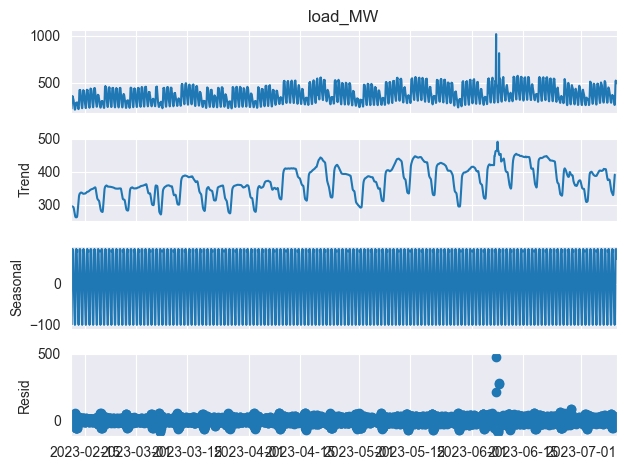

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

hourly_result = seasonal_decompose(df_hourly, model='additive', period=24)
hourly_result.plot()
plt.show()

# Average Load by 15-Minute Interval Across All Days


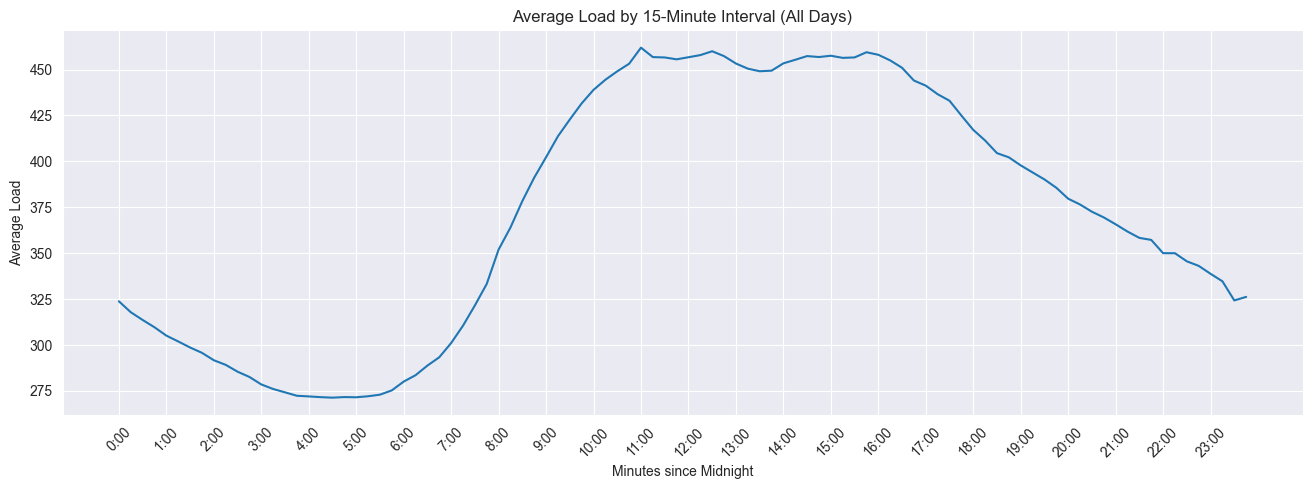

In [13]:
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Create a combined time-of-day label like "08:15"
df['time_of_day'] = df['hour'].astype(str).str.zfill(2) + ':' + df['minute'].astype(str).str.zfill(2)

# Or better: convert to minutes since midnight (useful for sorting)
df['minute_of_day'] = df['hour'] * 60 + df['minute']

# Group by minute of day (0–1435)
average_15min = df.groupby('minute_of_day')['load_MW'].mean()

# Plot
plt.figure(figsize=(16, 5))
plt.plot(average_15min.index, average_15min.values)
plt.title('Average Load by 15-Minute Interval (All Days)')
plt.xlabel('Minutes since Midnight')
plt.ylabel('Average Load')
plt.grid(True)
plt.xticks(ticks=range(0, 1440, 60), labels=[f"{h}:00" for h in range(24)], rotation=45)
plt.show()
